---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
license: "CC BY"
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

# The Illusion of Significance

> The Cost of p-Values

---
abstract: |
    Statistical models drive millions in spending decisions, yet beneath their precise-looking numbers lurks a dangerous problem. This post examines how the practice of selecting variables based on p-values creates a statistical house of cards; especially in Marketing Mix Modeling (MMM) and budget optimization. I show why common techniques like stepwise regression inevitably produce overconfident models with biased estimates that violate the very statistical principles they claim to uphold. These methodological flaws can result in money flowing to the wrong marketing channels based on **illusory** performance metrics. I demonstrate why Bayesian approaches offer a more honest alternative by naturally tempering overconfidence, incorporating what we already know, and providing intuitive uncertainty measures. Through techniques like spike-and-slab priors (or regularized horseshoe priors) and Bayesian Model Averaging (BMA), analysts can move beyond arbitrary significance thresholds toward probability-based decision-making. While Bayesian methods do require more computational horsepower and thoughtful prior specification, modern software has made them increasingly accessible. Using simulated examples inspired by real-world marketing and economic modeling, I show how Bayesian methods produce more reliable insights that lead to smarter budget allocation decisions.
---

## From Illusion to Insight — TLDR

We've all seen it (perhaps even presented it); the perfectly constructed model with impressive-looking p-values that is used to justify adding millions in budget to a particular marketing channel. But how much can we really trust these insights? Statistical modeling approaches that rely on p-value thresholds (or $\left| \text{t-stat}\right| > 1$) for variable selection create a fundamental problem: the same data that builds the model also validates it, creating a circular logic that **inevitably** results in overconfidence. Methods like stepwise regression don't just produce slightly inaccurate models: they systematically generate **biased coefficients**, **invalid statistical tests**, and **unstable predictions**. When these flawed models drive budget decisions, organizations end up misallocating resources based on what amounts to **statistical mirages** rather than **genuine insights**.

Bayesian statistics offers a more realistic alternative that acknowledges what traditional methods try to hide. **Uncertainty is real!** It should inform our decisions and not be artificially removed through statistical hocus-pocus for a slick deck. By treating parameters as variables with probability distributions and formally incorporating prior knowledge, Bayesian methods can help regularize models; prevent them from making wild claims the data can't support. Techniques like spike-and-slab priors let us evaluate which variables truly matter without arbitrary cutoffs, while Bayesian Model Averaging sensibly hedges bets across multiple plausible models rather than on a single one. Though implementing Bayesian approaches does require more computational power, technical skill, and careful thought about prior assumptions, the payoff is substantial: **more stable estimates**, **intuitive uncertainty measures** that stakeholders can actually understand (seriously what is a confidence interval), and ultimately, budget allocation **insights** based on reality rather than **statistical illusions**.

## Introduction: Modeling for Decision Making

### The Hidden Costs of Misspecification: Why Model Selection Matters

Statistical models, particularly within econometrics and marketing analytics, serve as critical instruments for dissecting complex business phenomena and guiding strategic decisions. Marketing Mix Modeling (MMM) stands as a prime example. The insights derived from MMM are frequently used for two primary purposes: understanding the historical contribution of different marketing levers and, crucially, optimizing future budget allocations to maximize return on investment (ROI). 

MMM's use extends beyond prediction toward causal inference: understanding the "true", incremental impact of altering a specific input, such as increasing social advertising spend, on the outcome variable (i.e. sales). This causal understanding is paramount for effective budget optimization.

However, standard modeling procedures, particularly those involving selection based on statistical significance, prioritize in-sample fit over robustness and causal validity. This focus inadvertently introduces substantial biases and instability. When models that systematically misrepresent causal effects guide budget decisions, organizations face significant resource misallocation that directly impacts profitability. The aggregated and time-series nature of marketing data further compounds these challenges, as weekly or monthly observations limit statistical power while still requiring controls for seasonality, economic trends, and competitive actions

As marketing analytics continues to drive increasingly larger investment decisions, the potential damage from flawed model specifications grows proportionally. This page examines how traditional variable selection approaches might generate misleading insights and offers a more robust Bayesian framework for addressing these methodological pitfalls.

### P-Value Selection: Common Pitfalls


The p-value is perhaps the most ubiquitous statistic in empirical research across many disciplines, including econometrics and marketing analytics. However, its widespread use is accompanied by pervasive misuse and misinterpretation. A p-value represents the probability of observing data as extreme as, or more extreme than, the data actually obtained, under the assumption that a specific null hypothesis (e.g., a regression coefficient being zero) is true. It is crucial to recognize that it does not represent the probability that the null hypothesis is true, nor the probability that the alternative hypothesis is false, given the data.

Furthermore, statistical significance, typically declared when a p-value falls below an arbitrary threshold like 0.05, is not synonymous with practical, economic, or causal importance. An effect can be statistically significant but trivially small in magnitude, especially in large datasets where even minute deviations from the null hypothesis can yield very small p-values.

Despite these limitations, p-values are frequently employed as the primary criterion in automated variable selection procedures, such as forward selection, backward elimination, and stepwise regression. These algorithms iteratively add or remove predictor variables from a model based on whether their associated p-values meet a predefined significance threshold, or based on related criteria like changes in R-squared or information criteria (AIC, BIC) which themselves have connections to significance testing. While seemingly objective and computationally convenient, this reliance on p-values for model construction introduces several severe pitfalls.

::: {.callout-note collapse=true}
## The math behind t-stats

In the context of linear regression the test statistic for the i-th coefficient estimate is given as: 

$$
\frac{\hat{\beta_i}}{\frac{\hat{\sigma}}{\sqrt{n\hat{\text{Var}}[X_i]}}\sqrt{VIF_i}}
$$

It's clear from the mathematical description of the test statistic that:

1. Coefficients ($\hat{\beta_i}$) with larger magnitudes — all else being equal — will be more "significant". 
2. Models with lower variance ($\hat{\sigma}$) will lead to all coefficients being more "significant".
3. Larger sample sizes (n) will increase all coefficients t-stat.
4. With increased variance in a predictor ($\hat{\sigma}$) — all else being equal — that predictor will be more "significant".
5. With increased correlation of covariate $X_i$ ($VIF_i$) — all else being equal — that predictor will be less "significant".
   
:::

#### Pitfall 1: P-hacking and Data Dredging
This refers to the practice of exploring multiple analytical choices—testing different variables, functional forms (transformations), subgroups, outlier handling rules, or data collection stopping points—and selectively reporting only those combinations that yield statistically significant p-values. This exploits the "researcher degrees of freedom"  inherent in data analysis. Stepwise regression procedures automate this process, systematically "dredging" the data for significant predictors based on p-value thresholds. This will occur even if multiple regressions aren't run. For example, if residuals of a model are peaked at and variables that seem to match that residual pattern are then added to the model.

#### Pitfall 2: Multiple Comparisons Problem
When numerous variables are tested for inclusion, as in stepwise methods, the probability of incorrectly finding at least one variable to be significant purely by chance (a Type I error or false positive) becomes substantially inflated. The p-values reported by standard software for the variables in the final selected model are typically not adjusted for the multitude of tests performed during the selection process. The probability of encountering at least one false positive grows exponentially with the number of potential predictors considered.

In [ ]:
#| hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import random_correlation
import statsmodels.api as sm
import pymc as pm
import arviz as az

In [ ]:
#| hide
np.random.seed(42)

::: {.callout-note collapse=true}
## Helper Functions

In [ ]:
def random_covariance(n_vars):
    """Create a random covariance matrix with a given correlation."""
    
    # Create a random correlation matrix
    A = np.random.randn(n_vars, n_vars)
    cov_matrix = np.dot(A, A.T)

    return cov_matrix

def create_data_no_signal(n_samples, n_vars, correlated=True):
    """Create completely random data with no signal."""
    
    mean = np.zeros(n_vars)
    if correlated:
        cov = random_covariance(n_signal_vars+n_noise_vars)
        var = np.diag(cov)
        # Ensure var of variables is 1
        cov = cov / np.sqrt(var[:, None] * var[None, :])
    else:
        cov = np.eye(n_signal_vars+n_noise_vars)

    X = np.random.multivariate_normal(
        mean=mean, 
        cov=cov, 
        size=n_samples
        )

    y = np.random.randn(n_samples)

    return pd.DataFrame(X), pd.Series(y)



def create_data_with_signal(
    n_samples, 
    n_signal_vars, 
    n_noise_vars, 
    betas = None,
    correlated = True,
    noise_level=1):
    """Create data with a signal in the first n_signal_vars."""
    
    mean = np.zeros(n_signal_vars+n_noise_vars)
    if correlated:
        cov = random_covariance(n_signal_vars+n_noise_vars)
        var = np.diag(cov)
        # Ensure var of variables is 1
        cov = cov / np.sqrt(var[:, None] * var[None, :])
    else:
        cov = np.eye(n_signal_vars+n_noise_vars)

    
    X = np.random.multivariate_normal(
        mean=mean, 
        cov=cov,
        size=n_samples)
    
    if betas is None:
        betas = np.zeros(n_signal_vars + n_noise_vars)
        betas[:n_signal_vars] = np.random.randn(n_signal_vars)
        
    assert len(betas) == n_signal_vars + n_noise_vars, "betas must have the same length as the number of variables"

    # Create a signal in the first n_signal_vars
    y = np.dot(X, betas) + np.random.randn(n_samples) * noise_level * np.var(np.dot(X, betas))

    return pd.DataFrame(X), pd.Series(y), betas

def forward_selection(
    X: pd.DataFrame, y: pd.Series,
    threshold_in=0.05
):
    """Perform forward selection with p-values to find the best subset of features."""
    
    # Initialize variables
    n_features = X.shape[1]
    selected_features = []
    remaining_features = list(X.columns)
    np.random.shuffle(remaining_features) # Shuffle features to simulate repeated runs
    
    # Perform forward selection with p-values
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            features = selected_features + [candidate]
            X_subset = X.loc[:, features]
            model = sm.OLS(y, sm.add_constant(X_subset)).fit()
            p_value = model.pvalues[candidate]
            
            scores_with_candidates.append((p_value, candidate))
        
        # Sort scores and select the best candidate
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if best_new_score < threshold_in:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
        else:
            break
    return selected_features

def backward_selection(
    X: pd.DataFrame, y: pd.Series,
    threshold_out=0.1
):
    """Perform backward selection with p-values to find the best subset of features."""
    
    # Initialize variables
    selected_features = list(X.columns)
    
    # Perform backward selection with p-values
    while selected_features:
        features = selected_features
        X_subset = X.loc[:, features]
        model = sm.OLS(y, sm.add_constant(X_subset)).fit()
        
        # Get the feature with the highest p-value
        p_values = model.pvalues[1:]  # Exclude intercept
        max_p_value = p_values.max()
        
        if max_p_value > threshold_out:
            feature_to_remove = p_values.idxmax()
            selected_features.remove(feature_to_remove)
        else:
            break
    return selected_features

:::

::: {.callout-note collapse=true}
## Simulate Variable Selection Based on P-Values

In [ ]:
n_trials = 1_000
n_samples = 100
n_signal_vars = 3
n_noise_vars = 20

X, y = create_data_no_signal(
    n_trials*n_samples,
    n_signal_vars+n_noise_vars, 
    correlated=False
)

X.columns = [f"X{i}" for i in range(X.shape[1])]
y.name = "y"


In [ ]:
forward_selected_vars = []
for trial in range(n_trials):
    trial_df = X.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y.loc[trial*n_samples:(trial+1)*n_samples-1]
    forward_selected_vars.append(
        forward_selection(
            trial_df, 
            trial_y, 
            threshold_in=0.05
        )
    )

In [ ]:
backward_selected_vars = []
for trial in range(n_trials):
    trial_df = X.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y.loc[trial*n_samples:(trial+1)*n_samples-1]
    backward_selected_vars.append(
        backward_selection(
            trial_df, 
            trial_y, 
            threshold_out=0.05
        )
    )

:::

::: {.panel-tabset}

## Backward Selection

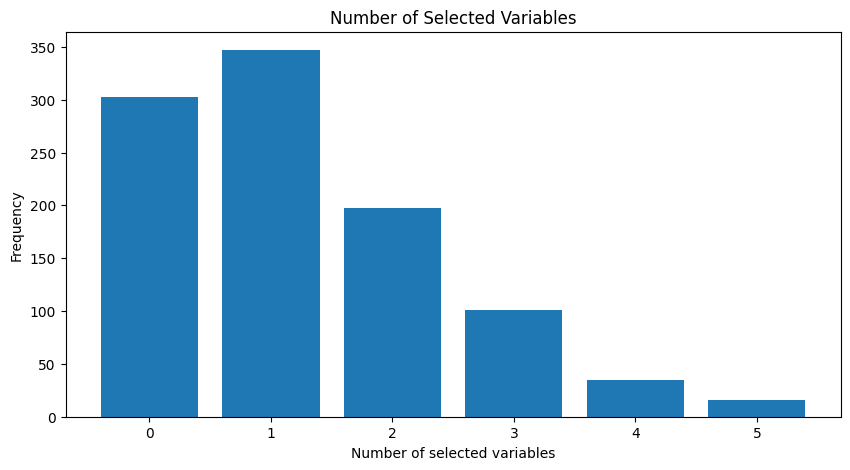

In [ ]:
#| echo: false
#| fig-cap: "Histogram of the number of selected variables in each trial using backward selection. The number of variables that are actually predictive are 0, however over 70% of the trials selected at least one variable as a statistically significant predictor."
#| label: fig-histogram-backward-selection
plt.figure(figsize=(10, 5))
n_vars_selected = np.array([len(set(v)) for v in backward_selected_vars])
plt.hist(n_vars_selected, bins=np.unique(n_vars_selected), align='left', rwidth=0.8)
plt.xlabel("Number of selected variables")
plt.ylabel("Frequency")
plt.title("Number of Selected Variables");

In [ ]:
#| echo: false
print(f"Family-wise error rate: {np.mean(n_vars_selected > 0):.1%}")

Family-wise error rate: 69.7%


## Foward Selection

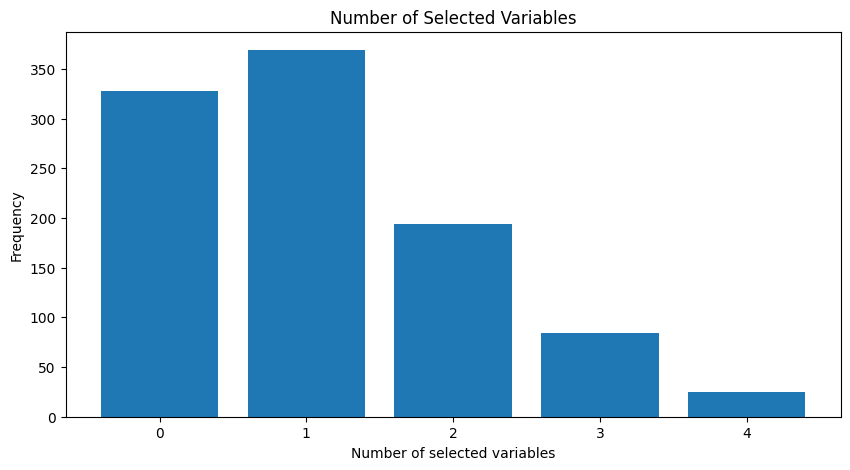

In [ ]:
#| echo: false
#| fig-cap: "Histogram of the number of selected variables in each trial using forward selection. The number of variables that are actually predictive are 0, however over 70% of the trials selected at least one variable as a statistically significant predictor."
#| label: fig-histogram-forward-selection
plt.figure(figsize=(10, 5))
n_vars_selected = np.array([len(set(v)) for v in forward_selected_vars])
plt.hist(n_vars_selected, bins=np.unique(n_vars_selected), align='left', rwidth=0.8)
plt.xlabel("Number of selected variables")
plt.ylabel("Frequency")
plt.title("Number of Selected Variables");

In [ ]:
#| echo: false
print(f"Family-wise error rate: {np.mean(n_vars_selected > 0):.1%}")

Family-wise error rate: 67.2%


:::

#### Pitfall 3: Overfitting
Models constructed through procedures that aggressively optimize for in-sample fit based on significance tests tend to overfit the data. They capture random noise and idiosyncrasies specific to the training sample, rather than the stable, underlying relationships. Consequently, these models often exhibit poor predictive performance when applied to new, independent datasets.

::: {.panel-tabset}

## Backward Selection

::: {.callout-note collapse=true}
## Model Analysis

In [ ]:
SELECTION_METHOD = backward_selected_vars
n_models_with_var = {
    var: sum([var in selected for selected in SELECTION_METHOD])
    for var in X.columns
}
in_sample_models = [
    sm.OLS(
        y.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

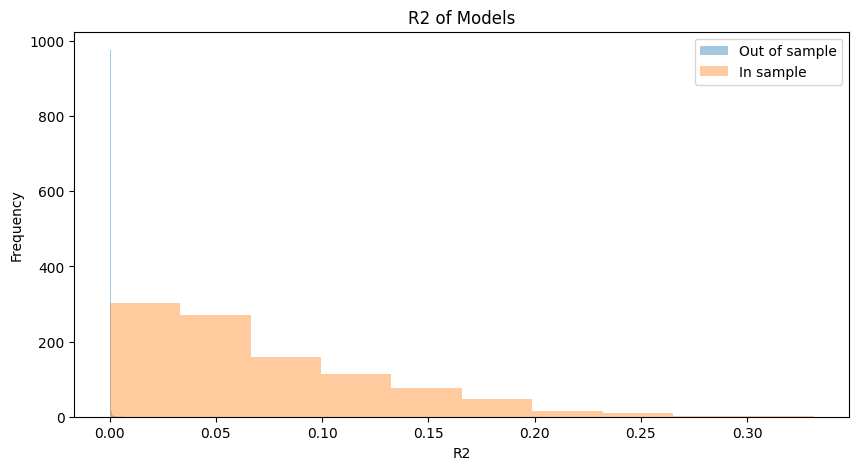

In [ ]:
#| echo: false
#| label: fig-histogram-backward-selection-r2
#| fig-cap: "In sample and out of sample R2 of the models selected using backward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample")
plt.hist(in_sample_r2, alpha=.4, label="In sample")
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

## Forward Selection

::: {.callout-note collapse=true}
## Model Analysis

In [ ]:
SELECTION_METHOD = forward_selected_vars
n_models_with_var = {
    var: sum([var in selected for selected in SELECTION_METHOD])
    for var in X.columns
}
in_sample_models = [
    sm.OLS(
        y.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

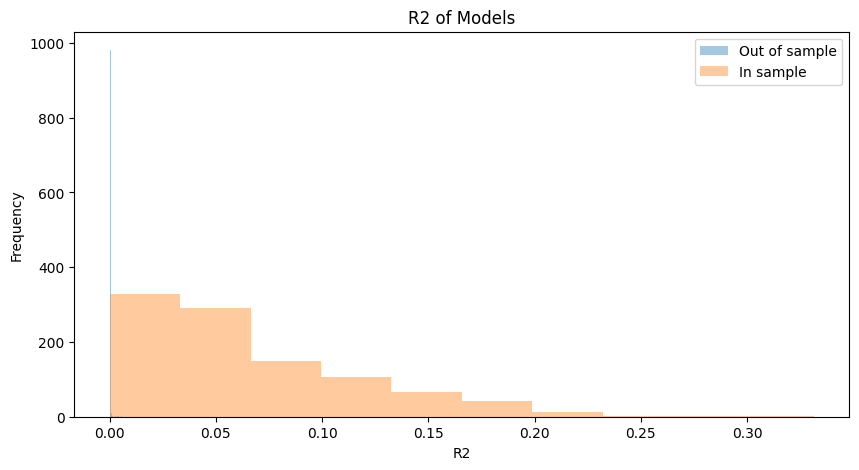

In [ ]:
#| echo: false
#| label: fig-histogram-forward-selection-r2
#| fig-cap: "In sample and out of sample R2 of the models selected using forward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample")
plt.hist(in_sample_r2, alpha=.4, label="In sample")
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

:::

::: {.callout-note collapse=true}
## Simulation with Signal

In [ ]:
betas = np.array([.2, .1, .3] + [0]*n_noise_vars)

X_signal, y_signal, betas = create_data_with_signal(
    n_trials*n_samples,
    n_signal_vars, 
    n_noise_vars, 
    correlated=True,
    betas=betas, 
    noise_level=3
)
X_signal.columns = [f"X{i}" for i in range(X_signal.shape[1])]
y_signal.name = "y"

In [ ]:
forward_selected_signal_vars = []
for trial in range(n_trials):
    trial_df = X_signal.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y_signal.loc[trial*n_samples:(trial+1)*n_samples-1]
    forward_selected_signal_vars.append(
        forward_selection(
            trial_df, 
            trial_y, 
            threshold_in=0.05
        )
    )

In [ ]:
backward_selected_signal_vars = []
for trial in range(n_trials):
    trial_df = X_signal.loc[trial*n_samples:(trial+1)*n_samples-1, :]
    trial_y = y_signal.loc[trial*n_samples:(trial+1)*n_samples-1]
    backward_selected_signal_vars.append(
        backward_selection(
            trial_df, 
            trial_y, 
            threshold_out=0.05
        )
    )

:::

::: {.panel-tabset}

## Forward Selection

::: {.callout-note collapse=true}

## Model Analysis

In [ ]:
SELECTION_METHOD = forward_selected_signal_vars

in_sample_models = [
    sm.OLS(
        y_signal.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y_signal.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X_signal[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y_signal.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y_signal.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

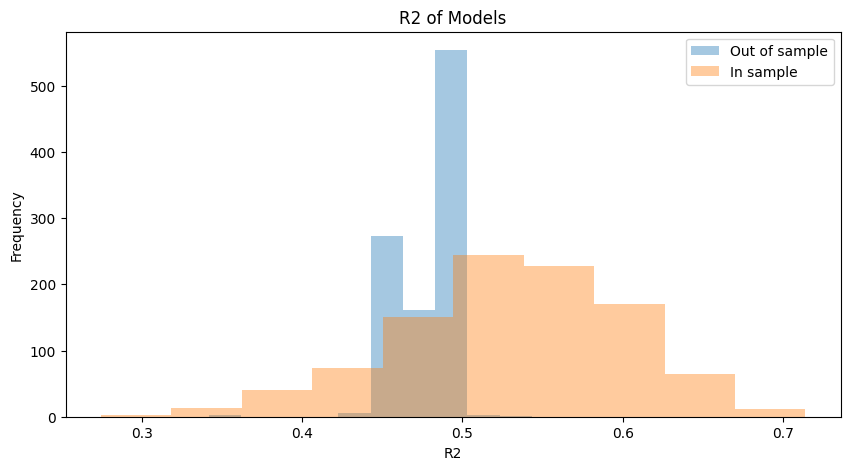

In [ ]:
#| echo: false
#| label: fig-histogram-forward-selection-r2-signal
#| fig-cap: "In sample and out of sample R2 of the models selected using forward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample")
plt.hist(in_sample_r2, alpha=.4, label="In sample")
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

## Backward Selection

::: {.callout-note collapse=true}

## Model Analysis

In [ ]:
SELECTION_METHOD = backward_selected_signal_vars

in_sample_models = [
    sm.OLS(
        y_signal.loc[i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[i*n_samples:(i+1)*n_samples-1, selected])
        ).fit() 
        for i, selected in enumerate(SELECTION_METHOD)
    ]
out_sample_model = [
    sm.OLS(
        y_signal.loc[~i*n_samples:(i+1)*n_samples-1], 
        sm.add_constant(X_signal.loc[~i*n_samples:(i+1)*n_samples-1, selected])
        ).fit()
        for i, selected in enumerate(SELECTION_METHOD)
    ]
in_sample_r2 = [model.rsquared for model in in_sample_models]
out_sample_r2 = [model.rsquared for model in out_sample_model]
predictions = [
    model.predict(sm.add_constant(X_signal[selected])) 
    for selected, model in zip(SELECTION_METHOD, in_sample_models)
]
out_of_sample_mse = [
    np.mean((
        y_signal.loc[~trial*n_samples:(trial+1)*n_samples-1] 
        - pred[~trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]
in_samples_mse = [
    np.mean((
        y_signal.loc[trial*n_samples:(trial+1)*n_samples-1] 
        - pred[trial*n_samples:(trial+1)*n_samples-1]
        )**2) 
    for trial, pred in enumerate(predictions)
]

:::

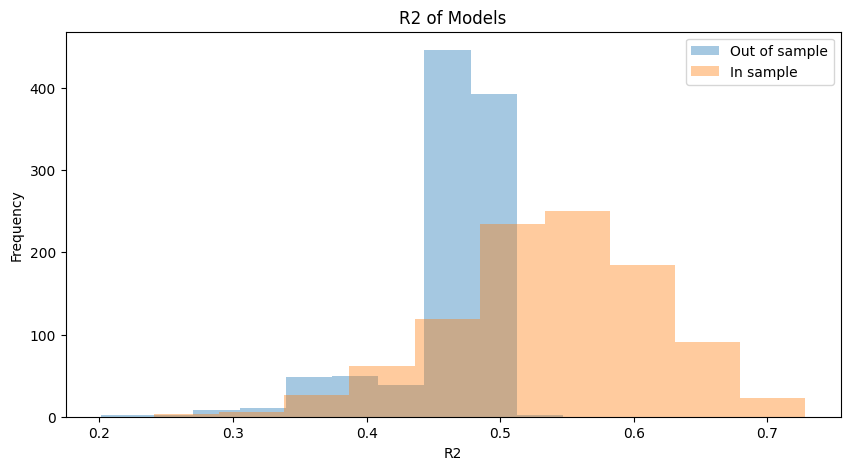

In [ ]:
#| echo: false
#| label: fig-histogram-backward-selection-r2-signal
#| fig-cap: "In sample and out of sample R2 of the models selected using backward selection. The models are each trained on 100 samples and tested on the remaining samples. This demonstrates the overfitting of the models."
plt.figure(figsize=(10, 5))
plt.hist(out_sample_r2, alpha=.4, label="Out of sample")
plt.hist(in_sample_r2, alpha=.4, label="In sample")
plt.title("R2 of Models")
plt.xlabel("R2")
plt.ylabel("Frequency")
plt.legend();

:::

#### Pitfall 4: Biased Coefficient Estimates
The regression coefficients associated with the variables selected through stepwise or p-value driven methods are systematically biased, typically inflated in magnitude (biased away from zero). This bias arises because the selection process inherently favors variables that, perhaps partly due to random sampling variation, exhibited stronger relationships with the outcome in the specific dataset used for model building.

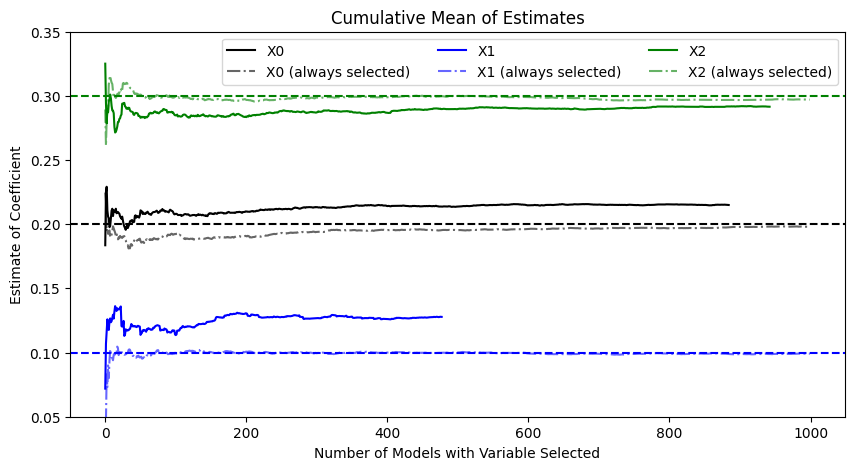

In [ ]:
#| echo: false
#| label: fig-bias-induced-by-selection
#| fig-cap: "The variable selection method systematically biases the coefficient estimates. This happens because models where the variable has a higher estimated effect are more likely to have that variable selected to be in the model. This is a form of selection bias."
in_sample_models_var_estimates = {f"X{i}": [model.params[f"X{i}"] for model in in_sample_models if f"X{i}" in model.params.index] for i in range(3)}
in_sample_models_var_cum_mean = {
    f"X{i}": np.cumsum(np.array(in_sample_models_var_estimates[f"X{i}"])) / np.arange(1, len(in_sample_models_var_estimates[f"X{i}"])+1)
    for i in range(3)
}

models_vars_always_selected = [sm.OLS(
    y_signal.loc[i*n_samples:(i+1)*n_samples-1], 
    sm.add_constant(X_signal.loc[i*n_samples:(i+1)*n_samples-1, ["X0", "X1", "X2"]+[var for var in np.random.choice(X_signal.columns[3:], 4, replace=False)]])
    ).fit() 
    for i in range(n_trials)
]

models_always_selected = {
    f'X{i}': [model.params[f'X{i}']
    for model in models_vars_always_selected]
    for i in range(3)
}
models_always_selected_cum_mean = {
    f'X{i}': np.cumsum(np.array(models_always_selected[f'X{i}'])) / np.arange(1, len(models_always_selected[f'X{i}'])+1)
    for i in range(3)
}
plt.figure(figsize=(10, 5))
plt.title("Cumulative Mean of Estimates")
plt.ylabel("Estimate of Coefficient")
plt.xlabel("Number of Models with Variable Selected")
plt.plot(in_sample_models_var_cum_mean["X0"], label="X0", color='k')
plt.plot(models_always_selected_cum_mean["X0"], label="X0 (always selected)", color='k', alpha=.6, linestyle="-.")
plt.axhline(betas[0], linestyle="--", color='k')
plt.plot(in_sample_models_var_cum_mean["X1"], label="X1", color='blue')
plt.plot(models_always_selected_cum_mean["X1"], label="X1 (always selected)", color='blue', alpha=.6, linestyle="-.")
plt.axhline(betas[1], color="blue", linestyle="--")
plt.plot(in_sample_models_var_cum_mean["X2"], label="X2", color='green')
plt.plot(models_always_selected_cum_mean["X2"], label="X2 (always selected)", color='green', alpha=.6, linestyle="-.")
plt.axhline(betas[2], color="green", linestyle="--")
plt.legend(ncols=3)
plt.ylim(0.05, 0.35);

#### Pitfall 5: Invalid Standard Errors, Confidence Intervals, and P-values
The standard errors calculated for the coefficients in the final, selected model are systematically underestimated. This leads to confidence intervals that are falsely narrow, suggesting greater precision than is warranted, and p-values that are artificially small, exaggerating statistical significance. Standard statistical inference relies on the assumption that the model structure was specified before examining the data. Applying these inferential tools after the model has been selected based on the data violates this fundamental assumption, rendering the resulting p-values, confidence intervals, and standard errors statistically invalid without specialized (and often complex) adjustments for the selection process.

#### Pitfall 6: Model Instability
The set of variables chosen by stepwise procedures can be highly sensitive to small perturbations in the data, particularly when predictor variables are correlated, a common issue in MMM. A slight change in the dataset might lead to a substantially different selected model.

#### Pitfall 7: Issues with Variable Transformations
The problems extend beyond selecting which variables to include; selecting the form of variables (e.g., choosing between linear, logarithmic, c-curve, or s-curve terms) based on p-values or fit statistics introduces the same risks. Optimizing transformations based on in-sample fit can lead to overfitting and results that do not generalize.

The root cause of these numerous pitfalls lies in the practice of using the same dataset for both model specification (choosing variables, choosing transformations) and subsequent statistical inference (calculating coefficients, standard errors, p-values, CIs). Frequentist statistical inference is predicated on the idea of evaluating a pre-specified hypothesis or model against the data. When the data itself is used to iteratively search for and construct the model that best fits it, the assumptions underpinning the calculation of p-values and confidence intervals are violated. The model is no longer a fixed entity being tested; it is a product of the data exploration process. Performing inference on this data-derived model as if it were pre-specified leads to a systematic underestimation of uncertainty and an overestimation of the significance and magnitude of the included effects.

### Consequences for Causal Interpretation and Decision Accuracy

The statistical pathologies induced by p-value driven variable selection have profound negative consequences, particularly when models are intended to inform causal understanding and guide high-stakes decisions like budget allocation.

Firstly, these methods are susceptible to identifying spurious correlations as statistically significant relationships. In time-series contexts like MMM, variables often exhibit trends or seasonality. Two variables trending together (e.g., ice cream sales and drowning incidents both rising in summer) can show a strong statistical correlation even without a direct causal link. P-value based selection, blind to the underlying causal structure, may readily incorporate such spurious predictors, muddying the interpretation of genuine effects and potentially reducing the precision of estimates for truly relevant variables.

Secondly, the arbitrary nature of significance thresholds can lead to omitted variable bias. A variable that is a genuine cause of the outcome and is correlated with included predictors (a confounder) might be excluded from the model simply because its p-value in the specific sample happens to fall above the 0.05 threshold. Omitting necessary confounders is a well-known source of bias in estimating the causal effects of the remaining variables.

Thirdly, automated selection procedures lack awareness of the causal roles variables play. They cannot distinguish between confounders (which should generally be included to block backdoor paths), mediators (which lie on the causal pathway and whose inclusion biases estimates of total effects), or colliders (which can induce spurious associations if conditioned upon). Selecting variables based solely on statistical association with the outcome, without considering the underlying causal graph (DAG), can lead to the inclusion of inappropriate variables (mediators, colliders) or the exclusion of necessary ones (confounders), severely compromising the model's ability to yield valid causal estimates.

These issues culminate in poor budget allocation decisions. The biased coefficients resulting from p-value driven selection provide a distorted picture of marketing effectiveness. ROI estimates for some channels might be artificially inflated, while others might be underestimated or even incorrectly estimated as negative. Allocating budgets based on these flawed estimates inevitably leads to suboptimal resource deployment, wasting money on ineffective channels and underinvesting in potentially high-return activities. The overconfidence stemming from falsely narrow confidence intervals further compounds this risk, leading decision-makers to believe their flawed estimates are more precise than they truly are.

Finally, the instability and sample-specificity of models built using these techniques contribute to a lack of reproducibility. A model selected based on the idiosyncrasies of one dataset is unlikely to perform well or yield the same variable set when applied to new data, hindering cumulative learning and reliable business forecasting.
In summary, the reliance on p-values for variable and transformation selection, while computationally convenient, fundamentally undermines the goal of building reliable and causally interpretable models for decision support. The resulting biases in coefficient estimates and the invalidity of standard statistical inferences directly translate into poor decision-making, particularly in the context of budget optimization where accurate estimation of incremental impact is essential.


## Core Statistical Challenges in MMM Selection
The selection of factors and transformations in MMM faces a confluence of statistical difficulties:

- **Multiple Testing Problem:** Simultaneously testing numerous potential external factors and functional forms for media variables drastically increases the probability of false positives (Type I errors). Standard significance thresholds (e.g., p < 0.05) are inadequate for controlling the overall error rate across such extensive testing.

- **Post-Selection Inference (PSI) Invalidity:** Standard statistical inference (p-values, confidence intervals) lacks theoretical validity when applied after model components have been selected using the same data. These post-selection metrics are often biased (e.g., p-values too small, confidence intervals too narrow), failing to maintain their nominal error rates or coverage probabilities.

- **Time-Series Complications:** MMM data's time-series nature introduces further challenges:

    - *Autocorrelation:* Residuals are often correlated over time, violating standard regression assumptions and rendering OLS p-values inaccurate.

    - *Non-stationarity:* Trends in variables can lead to spurious regression—finding significant relationships where none exist causally.

    - *Seasonality:* Unaccounted-for seasonal patterns can induce spurious correlations. These properties can invalidate the significance tests used during selection, compounding the problem.

### Multiple Testing Problem

### Post-Selection Inference (PSI) Invalidity

### Time-Series Complications

## Common Problematic Selection Practices in MMM
Several widely used methodologies are particularly susceptible to the challenges outlined above:

- **Stepwise Regression:** Automated procedures (forward, backward, bidirectional) iteratively add/remove variables based on significance thresholds. These are highly prone to multiple testing errors and instability, especially with autocorrelated or non-stationary time-series data, potentially selecting variables based on spurious correlations or invalid tests.

- **Significance-Based Transformation Selection:** Testing numerous functional forms (e.g., hundreds of adstock decays or saturation curves) for each media variable and selecting the one yielding the "most significant" coefficient represents a severe form of multiple testing, risking the selection of forms that fit noise.

- **Correlation Screening / Univariate Tests:** Selecting external factors based on simple correlations or individual significance tests ignores multicollinearity and is highly vulnerable to spurious findings driven by trends or seasonality, while also failing to account for multiple comparisons.

- **Best Subset Selection:** While potentially better if using information criteria (AIC/BIC), evaluating numerous model subsets still incurs a multiple testing burden and remains vulnerable to underlying time-series issues if not properly addressed within the model structure.

## Consequences of Flawed Selection in MMM
Employing naive selection methods and subsequent inference leads to significant practical problems:

- **Misattribution of ROI & Effects:** Biased estimates for marketing coefficients (ROI) and potentially inaccurate representations of media dynamics (adstock, saturation).

- **Flawed Budget Allocation:** Suboptimal marketing investment decisions stemming from unreliable ROI figures.

- **Poor Understanding of Business Drivers:** Incorrect identification of baseline factors (trends, seasonality, macroeconomics) and media response patterns.

- **Model Instability & Non-Reproducibility:** Selected factors and transformations may vary considerably with data updates, reducing model credibility.

- **Overfitting:** Models capture noise specific to the historical data, resulting in poor predictive performance for forecasting or simulations.

- **Misinterpretation of Control Factor Coefficients:** Attributing causal effects to the coefficients of baseline or control factors (e.g., macroeconomic variables, competitor activity) included in the model. These factors are typically observational and likely confounded themselves; their coefficients primarily reflect statistical association and adjustment needed to isolate media effects, not necessarily isolated causal impacts. This misinterpretation is related to the "Table 2 fallacy," where coefficients from a multivariable model are improperly treated as independent causal effects.

## Recommended Approaches and Considerations
Addressing these challenges requires more robust methodologies:

- **Rigorous Time-Series Handling:** Explicitly model or remove seasonality (e.g., dummies, Fourier terms, decomposition); test for and address non-stationarity (e.g., differencing); incorporate theoretically sound lags for media (adstock) and potentially external variables.

- **Regularization Methods (LASSO, Ridge, Elastic Net):** Handle many predictors simultaneously, perform coefficient shrinkage and implicit variable selection, often yielding more stable results than stepwise methods. Must be applied in conjunction with appropriate time-series structures.

- **Information Criteria (AIC, BIC):** Use for comparing non-nested models that correctly account for time-series properties, providing a more principled approach than p-value thresholds alone.

- **Time-Series Cross-Validation:** Employ methods like rolling-origin validation to assess out-of-sample predictive performance robustly.

- **Bayesian Frameworks:** Offer a probabilistic approach to uncertainty.

    - *Priors on Functional Forms:* Incorporate prior knowledge or average over plausible media transformations (adstock/saturation) instead of hard selection.

    - *Sparsity-Inducing Priors (e.g., Regularized Horseshoe):* Provide principled variable selection for external factors by shrinking irrelevant coefficients while retaining influential ones, directly modeling inclusion uncertainty.

- **Causal Inference Techniques:** Explore advanced time-series methods if the primary goal is establishing causal links (use with caution).

- **Domain Knowledge & Theory:** Prioritize pre-selecting candidate factors and transformation ranges based on business logic, economic theory, and prior research. Validate final model components for plausibility and stability.

::: {.callout-important}
## Improper Use of Domain Knowledge
Exogenous factors in MMM are frequently confounded with media variables or other unobserved drivers. Consequently, the estimated coefficient for an exogenous variable may not represent its direct causal impact on the outcome but rather the statistical adjustment necessary to deconfound the estimated media effects. Rejecting such a variable because its coefficient sign contradicts simple causal expectations might inadvertently remove a necessary control variable, potentially leading to more biased estimates of media effectiveness.
:::
Adopting these more rigorous approaches is fundamental to developing media mix models that are statistically sound, reliable, and strategically valuable.